## **A Quantum Enhanced Markov Chain Monte Carlo  Algorithm : Experiments & Simulation** 

Our aim in this project is to explore the idea of an **Quantum Enhanced** MCMC algorithm, which was proposed initially by *David Layden et al* in the this [article](https://arxiv.org/abs/2203.12497). Markov Chain Monte-Carlo is one of the fundamental tools available for a sampling tasks that arises in wide variety of computational problems. One specific area of interest is sampling from thermal distribution of Spin-Glass type hamiltonians at low tempeatures, where the energy landscape turns into a space of sparse energy minimas separated by wide barren plateaus making it difficult for usual algorithms to sample effectively.

The usual approach to this task is through the **Metropolis Algorithm**, whihc essentially consisits of two steps :
1. **Proposal Step :**  We propose a transition from the current state *s* to another state *s'*, with some probability $\mathbf{Q}(s \rightarrow s')$
2. **Acceptance Step :** Based on the sampling inverse-temperature $\beta$, we accept or reject the proposed transition with the probability $\mathbf{P}(s \rightarrow s') = min(1, e^{-\beta (\mathbf{E}(s') - \mathbf{E}(s))})$

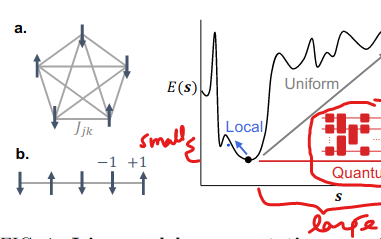